### 05 — Sessionization & Prefix→Target Generation

**Goal:**  
- For **Amazon Books 2023**: build synthetic sessions using **sliding windows** (Option A) to convert sparse user timelines into many sequence training examples.
- For **MARS**: sessionize by **1 hour gap** (as decided in Step 04).
- For **YOOCHOOSE**: use existing session IDs (already processed).
- Generate `prefix -> target` pairs for training (next-item prediction).
- Save outputs and report diagnostics.

Outputs saved to `data/processed/`:
- `amazon_windows_sessions.parquet` (or chunked files)
- `amazon_prefix_target.parquet` (or chunked)
- `mars_sessions.parquet`
- `mars_prefix_target.parquet`
- summary CSVs


In [1]:
# imports & settings
import pandas as pd     # Data manipulation and analysis
import numpy as np      # Numerical operations, especially array/matrix operations
from pathlib import Path  # Object-oriented filesystem paths
from tqdm import tqdm     # Progress bars for loops and iterations
import math             # Standard mathematical functions
import json             # Working with JSON data (parsing and serialization)
import shutil           # High-level file operations (copying, moving, deleting)
from collections import Counter # Utility for counting hashable objects

%matplotlib inline

DATA_DIR = Path("../data/processed")
OUT_DIR = DATA_DIR
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Parameters (tune as needed)
WINDOW_SIZE = 20    # number of items in a sliding window
STRIDE = 10         # step between windows
MIN_WINDOW_ITEMS = 2  # min items to keep a window (>=2 gives at least one pair)
MAX_PREFIX_LEN = 50  # cap prefix length when generating prefix-target
MIN_SESSION_LEN = 2
CHUNK_WRITE = True  # if True, write parquet in chunk files to avoid excessive RAM use


#### A — Helper functions
- `build_sliding_windows()` : builds sliding-window sessions for Amazon (memory-efficient).
- `sessionize_by_gap()` : sessionize a dataset by time-gap (used for MARS).
- `generate_prefix_target()` : generate prefix→target pairs from a sessions DataFrame.


In [2]:
# Cell: helper function definitions
def build_sliding_windows(df, user_col='user_id', item_col='item_id',
                          time_col='timestamp', window_size=WINDOW_SIZE, stride=STRIDE,
                          out_session_col='session_id_real'):
    """
    Build sliding-window synthetic sessions from a user timeline DataFrame.
    Returns a DataFrame with columns: dataset, user_id, session_id_real, item_id, timestamp
    This version streams per-user and yields rows to reduce peak memory usage.
    """
    rows = []
    # Ensure sorted
    df = df.sort_values([user_col, time_col])
    users = df[user_col].unique()
    total_users = len(users)
    print(f"Users to process: {total_users:,}")
    
    # iterate per user
    for user in tqdm(users, desc="Building windows per user"):
        user_slice = df[df[user_col] == user]
        items = user_slice[item_col].astype(str).tolist()
        times = pd.to_datetime(user_slice[time_col]).tolist()
        n = len(items)
        if n < MIN_WINDOW_ITEMS:
            continue
        start = 0
        win_idx = 0
        while start < n:
            end = min(start + window_size, n)
            window_items = items[start:end]
            window_times = times[start:end]
            if len(window_items) >= MIN_WINDOW_ITEMS:
                sess_id = f"{user}__w{win_idx}_{start}"
                for it, ts in zip(window_items, window_times):
                    rows.append({
                        "dataset": "amazon_books_2023",
                        "user_id": str(user),
                        out_session_col: sess_id,
                        "item_id": str(it),
                        "timestamp": pd.to_datetime(ts)
                    })
                win_idx += 1
            start += stride
            # if rows accumulate too large, yield in batches (handled by caller)
            if len(rows) >= 500_000:
                yield pd.DataFrame(rows)
                rows = []
    # final flush
    if rows:
        yield pd.DataFrame(rows)


def sessionize_by_gap(df, gap_seconds=3600, user_col='user_id', time_col='timestamp',
                      out_session_col='session_id_real'):
    """
    Sessionize by gap_seconds per user. Returns sessionized df and session summary.
    """
    df = df.sort_values([user_col, time_col]).copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df['prev_ts'] = df.groupby(user_col)[time_col].shift(1)
    df['gap_s'] = (df[time_col] - df['prev_ts']).dt.total_seconds()
    df['new_session'] = (df['gap_s'].isna()) | (df['gap_s'] > gap_seconds)
    df['sess_idx'] = df.groupby(user_col)['new_session'].cumsum().astype(int)
    df[out_session_col] = df[user_col].astype(str) + "__s" + df['sess_idx'].astype(str)
    # summary
    session_summary = df.groupby(out_session_col).agg(
        dataset=('dataset','first'),
        user_id=(user_col,'first'),
        start_time=(time_col,'min'),
        end_time=(time_col,'max'),
        session_length=('item_id','size')
    ).reset_index()
    # filter short and very long sessions
    valid_sessions = session_summary[
        (session_summary['session_length'] >= MIN_SESSION_LEN)
    ][out_session_col].tolist()
    df = df[df[out_session_col].isin(valid_sessions)].copy()
    df = df.drop(columns=['prev_ts','gap_s','new_session','sess_idx'], errors='ignore')
    return df, session_summary

def generate_prefix_target(df, session_col='session_id_real', item_col='item_id', max_prefix_len=MAX_PREFIX_LEN):
    """
    From a sessionized df ordered by timestamp, generate prefix->target pairs.
    Returns DataFrame with columns: dataset, user_id, session_id_real, prefix_len, prefix (space-separated), target
    """
    rows = []
    df = df.sort_values([session_col, 'timestamp'])
    grouped = df.groupby(session_col)
    for session_id, g in tqdm(grouped, desc="Generating prefix-target"):
        items = g[item_col].astype(str).tolist()
        if len(items) < 2: continue
        # optionally truncate to last (max_prefix_len + 1) items to limit explosion
        if len(items) > max_prefix_len + 1:
            items = items[-(max_prefix_len + 1):]
        for t in range(1, len(items)):
            prefix = items[:t]
            target = items[t]
            rows.append({
                'dataset': g['dataset'].iloc[0],
                'user_id': g['user_id'].iloc[0],
                session_col: session_id,
                'prefix_len': len(prefix),
                'prefix': " ".join(prefix),
                'target': str(target)
            })
        # flush periodically if very large
        if len(rows) >= 500_000:
            yield pd.DataFrame(rows)
            rows = []
    if rows:
        yield pd.DataFrame(rows)


In [3]:
# quick count per user (single-pass). If parquet fits in RAM we can do it with pandas.
path = Path("../data/processed/amazon_books_2023_interactions.parquet")
df = pd.read_parquet(path, columns=["user_id"])   # only this col -> lower memory
vc = df["user_id"].value_counts()
vc.describe(percentiles=[0.5,0.75,0.9,0.99])
print("fraction users with count==1:", (vc==1).mean())


fraction users with count==1: 0.5772661819019989


In [4]:
path = Path("../data/processed/amazon_books_2023_interactions.parquet")
# load only user_id column (fast)
df_u = pd.read_parquet(path, columns=["user_id"])
vc = df_u["user_id"].value_counts()
for cut in [1,2,3,5,10]:
    kept = (vc >= cut).sum()
    print(f"users with count >= {cut}: {kept:,}  (fraction={kept/len(vc):.4f})")
# top-K example
for k in [100_000, 500_000, 1_000_000]:
    topk = vc.nlargest(k).index.size
    print(f"top {k} users: {topk}")


users with count >= 1: 9,614,012  (fraction=1.0000)
users with count >= 2: 4,064,168  (fraction=0.4227)
users with count >= 3: 2,315,212  (fraction=0.2408)
users with count >= 5: 1,102,772  (fraction=0.1147)
users with count >= 10: 380,903  (fraction=0.0396)
top 100000 users: 100000
top 500000 users: 500000
top 1000000 users: 1000000


In [5]:
import duckdb
duckdb.sql("""
COPY (
  SELECT *
  FROM read_parquet('../data/processed/amazon_books_2023_interactions.parquet')
  WHERE user_id IN (
    SELECT user_id FROM read_parquet('../data/processed/amazon_books_2023_interactions.parquet')
    GROUP BY user_id HAVING COUNT(*) >= 2
  )
) TO '../data/processed/amazon_active_count_ge2.parquet' (FORMAT PARQUET);
""")
print("Created amazon_active_count_ge2.parquet")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created amazon_active_count_ge2.parquet


#### Step C — Build sliding windows from filtered file
Option C.1 — Single-process (simple, uses groupby)

In [6]:
# sessionize and generate prefix-target pairs

in_path = OUT_DIR / "amazon_active_count_ge2.parquet"  # or amazon_top1M.parquet

df = pd.read_parquet(in_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['user_id','timestamp'])

out_rows = []
out_parts = []
flush_every = 500000  # rows per part
part_idx = 0
count_rows = 0

for user, g in tqdm(df.groupby('user_id'), total=df['user_id'].nunique()):
    items = g['item_id'].astype(str).tolist()
    times = g['timestamp'].tolist()
    n = len(items)
    if n < MIN_WINDOW_ITEMS:
        continue
    start = 0
    win_idx = 0
    while start < n:
        end = min(start + WINDOW_SIZE, n)
        window_items = items[start:end]
        window_times = times[start:end]
        if len(window_items) >= MIN_WINDOW_ITEMS:
            sess_id = f"{user}__w{win_idx}_{start}"
            for it, ts in zip(window_items, window_times):
                out_rows.append({
                    "dataset": "amazon_books_2023",
                    "user_id": str(user),
                    "session_id_real": sess_id,
                    "item_id": str(it),
                    "timestamp": pd.to_datetime(ts)
                })
            win_idx += 1
        start += STRIDE
        if len(out_rows) >= flush_every:
            part = pd.DataFrame(out_rows)
            part_path = OUT_DIR / f"amazon_windows_sessions_part{part_idx:03d}.parquet"
            part.to_parquet(part_path, index=False)
            out_parts.append(part_path)
            count_rows += len(part)
            out_rows = []
            part_idx += 1

# final flush
if out_rows:
    part = pd.DataFrame(out_rows)
    part_path = OUT_DIR / f"amazon_windows_sessions_part{part_idx:03d}.parquet"
    part.to_parquet(part_path, index=False)
    out_parts.append(part_path)
    count_rows += len(part)

print("Wrote", len(out_parts), "parts; total rows:", count_rows)


100%|██████████| 4064168/4064168 [07:49<00:00, 8654.35it/s] 


Wrote 55 parts; total rows: 27036156


In [7]:
# sessionize and prefix-target

parts = sorted(DATA_DIR.glob("amazon_windows_sessions_part*.parquet"))
print("Found", len(parts), "parts")

# quick totals
total_events = 0
for p in parts:
    # read only number of rows — with pandas you get memory for that part only
    dfp = pd.read_parquet(p, columns=["session_id_real"])
    total_events += len(dfp)
print("Total events across parts:", total_events)


Found 55 parts
Total events across parts: 27036156


In [8]:

parts = sorted(DATA_DIR.glob("amazon_windows_sessions_part*.parquet"))
len(parts)
# create target folder
parts_dir = DATA_DIR / "amazon_windows_parts"
parts_dir.mkdir(exist_ok=True)

for p in parts:
    dest = parts_dir / p.name
    shutil.move(str(p), str(dest))

print("Moved", len(list(parts_dir.glob("amazon_windows_sessions_part*.parquet"))), "parts to", parts_dir)


Moved 55 parts to ..\data\processed\amazon_windows_parts


In [9]:
parts_dir = Path("../data/processed/amazon_windows_parts")
parts = sorted(parts_dir.glob("amazon_windows_sessions_part*.parquet"))
print("Found", len(parts), "parts")

sess_counter = Counter()
total_events = 0

for p in tqdm(parts, desc="Counting per-session lengths"):
    dfp = pd.read_parquet(p, columns=["session_id_real"])
    vc = dfp["session_id_real"].value_counts()
    total_events += len(dfp)
    # vc is a Series: index=session_id_real, value=count
    for sid, cnt in vc.items():
        sess_counter[sid] += int(cnt)

print("Total events counted across parts:", total_events)

# build DataFrame from Counter safely
sess_items = list(sess_counter.items())  # list of (session_id, length)
sess_df = pd.DataFrame(sess_items, columns=["session_id_real", "length"])
sess_df['length'] = sess_df['length'].astype(int)

print("Total sessions:", len(sess_df))
print(sess_df['length'].describe(percentiles=[.25,.5,.75,.9,.95,.99]))


Found 55 parts


Counting per-session lengths: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]


Total events counted across parts: 27036156
Total sessions: 4745988
count    4.745988e+06
mean     5.696634e+00
std      5.563629e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
90%      1.700000e+01
95%      2.000000e+01
99%      2.000000e+01
max      2.000000e+01
Name: length, dtype: float64


In [10]:
sess_df.to_csv(DATA_DIR / "amazon_windows_session_summary.csv", index=False)
print("Saved session summary to", DATA_DIR / "amazon_windows_session_summary.csv")


Saved session summary to ..\data\processed\amazon_windows_session_summary.csv


#### D — Generate prefix→target pairs for Amazon (stream chunked parts)
Read each window-session chunk and generate prefix-target pairs streaming to chunked parquet files.


In [11]:
parts_dir = Path("../data/processed/amazon_windows_parts")
pair_out_dir = Path("../data/processed/amazon_prefix_parts")
pair_out_dir.mkdir(exist_ok=True)

FLUSH = 200_000
pair_idx = 0
total_pairs = 0

def gen_pairs_from_df(df_part, session_col='session_id_real', item_col='item_id', max_prefix_len=50):
    df_part = df_part.sort_values([session_col, 'timestamp'])
    rows = []
    for session_id, g in df_part.groupby(session_col):
        items = g[item_col].astype(str).tolist()
        if len(items) < 2:
            continue
        if len(items) > max_prefix_len + 1:
            items = items[-(max_prefix_len + 1):]
        for t in range(1, len(items)):
            rows.append({
                'dataset': g['dataset'].iloc[0],
                'user_id': g['user_id'].iloc[0],
                session_col: session_id,
                'prefix_len': t,
                'prefix': " ".join(items[:t]),
                'target': str(items[t])
            })
            if len(rows) >= FLUSH:
                yield pd.DataFrame(rows)
                rows = []
    if rows:
        yield pd.DataFrame(rows)

# process each part file and write pair-parquet parts
for p in tqdm(parts, desc="Generating prefix-target parts"):
    dfp = pd.read_parquet(p)
    for df_pairs in gen_pairs_from_df(dfp, max_prefix_len=50):
        outp = pair_out_dir / f"amazon_prefix_target_part{pair_idx:04d}.parquet"
        df_pairs.to_parquet(outp, index=False)
        total_pairs += len(df_pairs)
        pair_idx += 1
        print(f"Wrote {outp} (#pairs={len(df_pairs):,}); total_pairs={total_pairs:,}")

print("Done. Total prefix-target pairs:", total_pairs)


Generating prefix-target parts:   0%|          | 0/55 [00:00<?, ?it/s]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0000.parquet (#pairs=200,000); total_pairs=200,000
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0001.parquet (#pairs=200,000); total_pairs=400,000


Generating prefix-target parts:   2%|▏         | 1/55 [00:12<10:54, 12.12s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0002.parquet (#pairs=12,544); total_pairs=412,544
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0003.parquet (#pairs=200,000); total_pairs=612,544
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0004.parquet (#pairs=200,000); total_pairs=812,544


Generating prefix-target parts:   4%|▎         | 2/55 [00:24<10:39, 12.06s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0005.parquet (#pairs=10,989); total_pairs=823,533
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0006.parquet (#pairs=200,000); total_pairs=1,023,533
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0007.parquet (#pairs=200,000); total_pairs=1,223,533


Generating prefix-target parts:   5%|▌         | 3/55 [00:35<10:21, 11.96s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0008.parquet (#pairs=12,115); total_pairs=1,235,648
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0009.parquet (#pairs=200,000); total_pairs=1,435,648
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0010.parquet (#pairs=200,000); total_pairs=1,635,648


Generating prefix-target parts:   7%|▋         | 4/55 [00:47<10:06, 11.89s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0011.parquet (#pairs=12,875); total_pairs=1,648,523
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0012.parquet (#pairs=200,000); total_pairs=1,848,523
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0013.parquet (#pairs=200,000); total_pairs=2,048,523


Generating prefix-target parts:   9%|▉         | 5/55 [00:59<09:55, 11.92s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0014.parquet (#pairs=10,463); total_pairs=2,058,986
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0015.parquet (#pairs=200,000); total_pairs=2,258,986
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0016.parquet (#pairs=200,000); total_pairs=2,458,986


Generating prefix-target parts:  11%|█         | 6/55 [01:11<09:41, 11.87s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0017.parquet (#pairs=10,699); total_pairs=2,469,685
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0018.parquet (#pairs=200,000); total_pairs=2,669,685
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0019.parquet (#pairs=200,000); total_pairs=2,869,685


Generating prefix-target parts:  13%|█▎        | 7/55 [01:23<09:27, 11.83s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0020.parquet (#pairs=12,183); total_pairs=2,881,868
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0021.parquet (#pairs=200,000); total_pairs=3,081,868
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0022.parquet (#pairs=200,000); total_pairs=3,281,868


Generating prefix-target parts:  15%|█▍        | 8/55 [01:35<09:16, 11.83s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0023.parquet (#pairs=11,524); total_pairs=3,293,392
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0024.parquet (#pairs=200,000); total_pairs=3,493,392
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0025.parquet (#pairs=200,000); total_pairs=3,693,392


Generating prefix-target parts:  16%|█▋        | 9/55 [01:47<09:05, 11.86s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0026.parquet (#pairs=12,619); total_pairs=3,706,011
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0027.parquet (#pairs=200,000); total_pairs=3,906,011
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0028.parquet (#pairs=200,000); total_pairs=4,106,011


Generating prefix-target parts:  18%|█▊        | 10/55 [01:58<08:53, 11.86s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0029.parquet (#pairs=10,746); total_pairs=4,116,757
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0030.parquet (#pairs=200,000); total_pairs=4,316,757
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0031.parquet (#pairs=200,000); total_pairs=4,516,757


Generating prefix-target parts:  20%|██        | 11/55 [02:10<08:45, 11.93s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0032.parquet (#pairs=13,252); total_pairs=4,530,009
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0033.parquet (#pairs=200,000); total_pairs=4,730,009
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0034.parquet (#pairs=200,000); total_pairs=4,930,009


Generating prefix-target parts:  22%|██▏       | 12/55 [02:22<08:32, 11.92s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0035.parquet (#pairs=11,433); total_pairs=4,941,442
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0036.parquet (#pairs=200,000); total_pairs=5,141,442
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0037.parquet (#pairs=200,000); total_pairs=5,341,442


Generating prefix-target parts:  24%|██▎       | 13/55 [02:34<08:20, 11.91s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0038.parquet (#pairs=10,992); total_pairs=5,352,434
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0039.parquet (#pairs=200,000); total_pairs=5,552,434
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0040.parquet (#pairs=200,000); total_pairs=5,752,434


Generating prefix-target parts:  25%|██▌       | 14/55 [02:46<08:11, 12.00s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0041.parquet (#pairs=11,429); total_pairs=5,763,863
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0042.parquet (#pairs=200,000); total_pairs=5,963,863
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0043.parquet (#pairs=200,000); total_pairs=6,163,863


Generating prefix-target parts:  27%|██▋       | 15/55 [02:58<07:58, 11.96s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0044.parquet (#pairs=12,463); total_pairs=6,176,326
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0045.parquet (#pairs=200,000); total_pairs=6,376,326
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0046.parquet (#pairs=200,000); total_pairs=6,576,326


Generating prefix-target parts:  29%|██▉       | 16/55 [03:10<07:45, 11.93s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0047.parquet (#pairs=12,935); total_pairs=6,589,261
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0048.parquet (#pairs=200,000); total_pairs=6,789,261
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0049.parquet (#pairs=200,000); total_pairs=6,989,261


Generating prefix-target parts:  31%|███       | 17/55 [03:22<07:31, 11.88s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0050.parquet (#pairs=11,643); total_pairs=7,000,904
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0051.parquet (#pairs=200,000); total_pairs=7,200,904
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0052.parquet (#pairs=200,000); total_pairs=7,400,904


Generating prefix-target parts:  33%|███▎      | 18/55 [03:34<07:17, 11.83s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0053.parquet (#pairs=12,216); total_pairs=7,413,120
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0054.parquet (#pairs=200,000); total_pairs=7,613,120
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0055.parquet (#pairs=200,000); total_pairs=7,813,120


Generating prefix-target parts:  35%|███▍      | 19/55 [03:45<07:04, 11.78s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0056.parquet (#pairs=12,782); total_pairs=7,825,902
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0057.parquet (#pairs=200,000); total_pairs=8,025,902
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0058.parquet (#pairs=200,000); total_pairs=8,225,902


Generating prefix-target parts:  36%|███▋      | 20/55 [03:57<06:51, 11.76s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0059.parquet (#pairs=12,893); total_pairs=8,238,795
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0060.parquet (#pairs=200,000); total_pairs=8,438,795
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0061.parquet (#pairs=200,000); total_pairs=8,638,795


Generating prefix-target parts:  38%|███▊      | 21/55 [04:09<06:39, 11.75s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0062.parquet (#pairs=13,678); total_pairs=8,652,473
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0063.parquet (#pairs=200,000); total_pairs=8,852,473
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0064.parquet (#pairs=200,000); total_pairs=9,052,473


Generating prefix-target parts:  40%|████      | 22/55 [04:20<06:27, 11.73s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0065.parquet (#pairs=12,465); total_pairs=9,064,938
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0066.parquet (#pairs=200,000); total_pairs=9,264,938
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0067.parquet (#pairs=200,000); total_pairs=9,464,938


Generating prefix-target parts:  42%|████▏     | 23/55 [04:32<06:14, 11.71s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0068.parquet (#pairs=12,540); total_pairs=9,477,478
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0069.parquet (#pairs=200,000); total_pairs=9,677,478
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0070.parquet (#pairs=200,000); total_pairs=9,877,478


Generating prefix-target parts:  44%|████▎     | 24/55 [04:44<06:03, 11.73s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0071.parquet (#pairs=10,936); total_pairs=9,888,414
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0072.parquet (#pairs=200,000); total_pairs=10,088,414
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0073.parquet (#pairs=200,000); total_pairs=10,288,414


Generating prefix-target parts:  45%|████▌     | 25/55 [04:56<05:53, 11.78s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0074.parquet (#pairs=12,298); total_pairs=10,300,712
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0075.parquet (#pairs=200,000); total_pairs=10,500,712
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0076.parquet (#pairs=200,000); total_pairs=10,700,712


Generating prefix-target parts:  47%|████▋     | 26/55 [05:07<05:40, 11.73s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0077.parquet (#pairs=12,458); total_pairs=10,713,170
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0078.parquet (#pairs=200,000); total_pairs=10,913,170
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0079.parquet (#pairs=200,000); total_pairs=11,113,170


Generating prefix-target parts:  49%|████▉     | 27/55 [05:19<05:29, 11.77s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0080.parquet (#pairs=10,526); total_pairs=11,123,696
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0081.parquet (#pairs=200,000); total_pairs=11,323,696
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0082.parquet (#pairs=200,000); total_pairs=11,523,696


Generating prefix-target parts:  51%|█████     | 28/55 [05:31<05:16, 11.72s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0083.parquet (#pairs=13,445); total_pairs=11,537,141
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0084.parquet (#pairs=200,000); total_pairs=11,737,141
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0085.parquet (#pairs=200,000); total_pairs=11,937,141


Generating prefix-target parts:  53%|█████▎    | 29/55 [05:43<05:06, 11.80s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0086.parquet (#pairs=11,204); total_pairs=11,948,345
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0087.parquet (#pairs=200,000); total_pairs=12,148,345
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0088.parquet (#pairs=200,000); total_pairs=12,348,345


Generating prefix-target parts:  55%|█████▍    | 30/55 [05:55<04:57, 11.90s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0089.parquet (#pairs=12,325); total_pairs=12,360,670
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0090.parquet (#pairs=200,000); total_pairs=12,560,670
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0091.parquet (#pairs=200,000); total_pairs=12,760,670


Generating prefix-target parts:  56%|█████▋    | 31/55 [06:07<04:46, 11.94s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0092.parquet (#pairs=10,191); total_pairs=12,770,861
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0093.parquet (#pairs=200,000); total_pairs=12,970,861
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0094.parquet (#pairs=200,000); total_pairs=13,170,861


Generating prefix-target parts:  58%|█████▊    | 32/55 [06:19<04:34, 11.93s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0095.parquet (#pairs=11,914); total_pairs=13,182,775
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0096.parquet (#pairs=200,000); total_pairs=13,382,775
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0097.parquet (#pairs=200,000); total_pairs=13,582,775


Generating prefix-target parts:  60%|██████    | 33/55 [06:31<04:21, 11.87s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0098.parquet (#pairs=12,187); total_pairs=13,594,962
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0099.parquet (#pairs=200,000); total_pairs=13,794,962
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0100.parquet (#pairs=200,000); total_pairs=13,994,962


Generating prefix-target parts:  62%|██████▏   | 34/55 [06:43<04:09, 11.90s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0101.parquet (#pairs=10,705); total_pairs=14,005,667
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0102.parquet (#pairs=200,000); total_pairs=14,205,667
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0103.parquet (#pairs=200,000); total_pairs=14,405,667


Generating prefix-target parts:  64%|██████▎   | 35/55 [06:54<03:57, 11.86s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0104.parquet (#pairs=11,652); total_pairs=14,417,319
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0105.parquet (#pairs=200,000); total_pairs=14,617,319
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0106.parquet (#pairs=200,000); total_pairs=14,817,319


Generating prefix-target parts:  65%|██████▌   | 36/55 [07:06<03:44, 11.81s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0107.parquet (#pairs=12,190); total_pairs=14,829,509
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0108.parquet (#pairs=200,000); total_pairs=15,029,509
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0109.parquet (#pairs=200,000); total_pairs=15,229,509


Generating prefix-target parts:  67%|██████▋   | 37/55 [07:18<03:33, 11.86s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0110.parquet (#pairs=12,720); total_pairs=15,242,229
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0111.parquet (#pairs=200,000); total_pairs=15,442,229
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0112.parquet (#pairs=200,000); total_pairs=15,642,229


Generating prefix-target parts:  69%|██████▉   | 38/55 [07:30<03:21, 11.88s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0113.parquet (#pairs=12,806); total_pairs=15,655,035
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0114.parquet (#pairs=200,000); total_pairs=15,855,035
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0115.parquet (#pairs=200,000); total_pairs=16,055,035


Generating prefix-target parts:  71%|███████   | 39/55 [07:42<03:09, 11.84s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0116.parquet (#pairs=13,661); total_pairs=16,068,696
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0117.parquet (#pairs=200,000); total_pairs=16,268,696
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0118.parquet (#pairs=200,000); total_pairs=16,468,696


Generating prefix-target parts:  73%|███████▎  | 40/55 [07:54<02:57, 11.85s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0119.parquet (#pairs=12,032); total_pairs=16,480,728
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0120.parquet (#pairs=200,000); total_pairs=16,680,728
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0121.parquet (#pairs=200,000); total_pairs=16,880,728


Generating prefix-target parts:  75%|███████▍  | 41/55 [08:06<02:46, 11.92s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0122.parquet (#pairs=14,613); total_pairs=16,895,341
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0123.parquet (#pairs=200,000); total_pairs=17,095,341
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0124.parquet (#pairs=200,000); total_pairs=17,295,341


Generating prefix-target parts:  76%|███████▋  | 42/55 [08:18<02:37, 12.08s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0125.parquet (#pairs=11,968); total_pairs=17,307,309
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0126.parquet (#pairs=200,000); total_pairs=17,507,309
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0127.parquet (#pairs=200,000); total_pairs=17,707,309


Generating prefix-target parts:  78%|███████▊  | 43/55 [08:30<02:24, 12.07s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0128.parquet (#pairs=14,245); total_pairs=17,721,554
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0129.parquet (#pairs=200,000); total_pairs=17,921,554
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0130.parquet (#pairs=200,000); total_pairs=18,121,554


Generating prefix-target parts:  80%|████████  | 44/55 [08:42<02:11, 11.99s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0131.parquet (#pairs=14,598); total_pairs=18,136,152
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0132.parquet (#pairs=200,000); total_pairs=18,336,152
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0133.parquet (#pairs=200,000); total_pairs=18,536,152


Generating prefix-target parts:  82%|████████▏ | 45/55 [08:55<02:02, 12.21s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0134.parquet (#pairs=11,179); total_pairs=18,547,331
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0135.parquet (#pairs=200,000); total_pairs=18,747,331
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0136.parquet (#pairs=200,000); total_pairs=18,947,331


Generating prefix-target parts:  84%|████████▎ | 46/55 [09:07<01:49, 12.13s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0137.parquet (#pairs=11,880); total_pairs=18,959,211
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0138.parquet (#pairs=200,000); total_pairs=19,159,211
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0139.parquet (#pairs=200,000); total_pairs=19,359,211


Generating prefix-target parts:  85%|████████▌ | 47/55 [09:19<01:36, 12.06s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0140.parquet (#pairs=11,501); total_pairs=19,370,712
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0141.parquet (#pairs=200,000); total_pairs=19,570,712
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0142.parquet (#pairs=200,000); total_pairs=19,770,712


Generating prefix-target parts:  87%|████████▋ | 48/55 [09:30<01:23, 11.97s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0143.parquet (#pairs=16,700); total_pairs=19,787,412
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0144.parquet (#pairs=200,000); total_pairs=19,987,412
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0145.parquet (#pairs=200,000); total_pairs=20,187,412


Generating prefix-target parts:  89%|████████▉ | 49/55 [09:42<01:11, 11.90s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0146.parquet (#pairs=12,848); total_pairs=20,200,260
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0147.parquet (#pairs=200,000); total_pairs=20,400,260
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0148.parquet (#pairs=200,000); total_pairs=20,600,260


Generating prefix-target parts:  91%|█████████ | 50/55 [09:54<00:59, 11.90s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0149.parquet (#pairs=12,466); total_pairs=20,612,726
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0150.parquet (#pairs=200,000); total_pairs=20,812,726
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0151.parquet (#pairs=200,000); total_pairs=21,012,726


Generating prefix-target parts:  93%|█████████▎| 51/55 [10:06<00:47, 11.97s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0152.parquet (#pairs=10,903); total_pairs=21,023,629
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0153.parquet (#pairs=200,000); total_pairs=21,223,629
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0154.parquet (#pairs=200,000); total_pairs=21,423,629


Generating prefix-target parts:  95%|█████████▍| 52/55 [10:18<00:35, 11.97s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0155.parquet (#pairs=11,802); total_pairs=21,435,431
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0156.parquet (#pairs=200,000); total_pairs=21,635,431
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0157.parquet (#pairs=200,000); total_pairs=21,835,431


Generating prefix-target parts:  96%|█████████▋| 53/55 [10:30<00:23, 11.90s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0158.parquet (#pairs=13,541); total_pairs=21,848,972
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0159.parquet (#pairs=200,000); total_pairs=22,048,972
Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0160.parquet (#pairs=200,000); total_pairs=22,248,972


Generating prefix-target parts:  98%|█████████▊| 54/55 [10:42<00:11, 11.93s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0161.parquet (#pairs=11,143); total_pairs=22,260,115


Generating prefix-target parts: 100%|██████████| 55/55 [10:43<00:00, 11.69s/it]

Wrote ..\data\processed\amazon_prefix_parts\amazon_prefix_target_part0162.parquet (#pairs=30,053); total_pairs=22,290,168
Done. Total prefix-target pairs: 22290168


In [12]:
# session-summary (fixed) + streaming prefix->target generation to a dedicated folder

parts_dir = DATA_DIR / "amazon_windows_parts"   # folder with amazon_windows_sessions_part*.parquet
pair_out_dir = DATA_DIR / "amazon_prefix_parts"
pair_out_dir.mkdir(exist_ok=True)

# --- 1) session-length aggregation across parts ---
parts = sorted(parts_dir.glob("amazon_windows_sessions_part*.parquet"))
print("Found parts:", len(parts))
sess_counter = Counter()
total_events = 0

for p in tqdm(parts, desc="Counting per-session lengths"):
    dfp = pd.read_parquet(p, columns=["session_id_real"])
    vc = dfp["session_id_real"].value_counts()
    total_events += len(dfp)
    for sid, cnt in vc.items():
        sess_counter[sid] += int(cnt)

# convert Counter -> DataFrame
sess_items = list(sess_counter.items())
sess_df = pd.DataFrame(sess_items, columns=["session_id_real", "length"])
sess_df['length'] = sess_df['length'].astype(int)
print("Total events counted across parts:", total_events)
print("Total sessions:", len(sess_df))
print(sess_df['length'].describe(percentiles=[.25,.5,.75,.9,.95,.99]))

# Save session summary
sess_summary_path = DATA_DIR / "amazon_windows_session_summary_from_parts.csv"
sess_df.to_csv(sess_summary_path, index=False)
print("Saved session summary CSV to:", sess_summary_path)

# --- 2) Generate prefix->target parts streaming from window parts ---
FLUSH = 200_000   # number of pairs per output parquet file (tune if needed)
pair_idx = 0
total_pairs = 0

def gen_pairs_from_df(df_part, session_col='session_id_real', item_col='item_id', max_prefix_len=50):
    df_part = df_part.sort_values([session_col, 'timestamp'])
    rows = []
    for session_id, g in df_part.groupby(session_col):
        items = g[item_col].astype(str).tolist()
        if len(items) < 2:
            continue
        if len(items) > max_prefix_len + 1:
            items = items[-(max_prefix_len + 1):]
        for t in range(1, len(items)):
            rows.append({
                'dataset': g['dataset'].iloc[0],
                'user_id': g['user_id'].iloc[0],
                session_col: session_id,
                'prefix_len': t,
                'prefix': " ".join(items[:t]),
                'target': str(items[t])
            })
            if len(rows) >= FLUSH:
                yield pd.DataFrame(rows)
                rows = []
    if rows:
        yield pd.DataFrame(rows)

print("\nStart generating prefix->target parts (this can take time)...")
for p in tqdm(parts, desc="Generating pairs from parts"):
    dfp = pd.read_parquet(p)
    for df_pairs in gen_pairs_from_df(dfp, max_prefix_len=50):
        outp = pair_out_dir / f"amazon_prefix_target_part{pair_idx:04d}.parquet"
        df_pairs.to_parquet(outp, index=False)
        total_pairs += len(df_pairs)
        pair_idx += 1
        print(f"Wrote {outp.name}  (#pairs={len(df_pairs):,})  total_pairs={total_pairs:,}")

print("\nDone generating prefix-target pairs.")
print("Total prefix-target parts written:", len(list(pair_out_dir.glob("amazon_prefix_target_part*.parquet"))))
print("Total pairs generated:", total_pairs)

# Save small manifest of parts for downstream notebooks
manifest = {
    "amazon_window_parts_dir": str(parts_dir),
    "amazon_window_parts_count": len(parts),
    "amazon_prefix_parts_dir": str(pair_out_dir),
    "amazon_prefix_parts_count": len(list(pair_out_dir.glob("amazon_prefix_target_part*.parquet"))),
    "total_pairs": total_pairs,
    "session_summary_csv": str(sess_summary_path)
}
with open(DATA_DIR / "amazon_parts_and_pairs_manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)
print("Saved manifest:", DATA_DIR / "amazon_parts_and_pairs_manifest.json")


Found parts: 55


Counting per-session lengths: 100%|██████████| 55/55 [00:09<00:00,  5.81it/s]


Total events counted across parts: 27036156
Total sessions: 4745988
count    4.745988e+06
mean     5.696634e+00
std      5.563629e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
90%      1.700000e+01
95%      2.000000e+01
99%      2.000000e+01
max      2.000000e+01
Name: length, dtype: float64
Saved session summary CSV to: ..\data\processed\amazon_windows_session_summary_from_parts.csv

Start generating prefix->target parts (this can take time)...


Generating pairs from parts:   0%|          | 0/55 [00:00<?, ?it/s]

Wrote amazon_prefix_target_part0000.parquet  (#pairs=200,000)  total_pairs=200,000
Wrote amazon_prefix_target_part0001.parquet  (#pairs=200,000)  total_pairs=400,000


Generating pairs from parts:   2%|▏         | 1/55 [00:11<10:43, 11.91s/it]

Wrote amazon_prefix_target_part0002.parquet  (#pairs=12,544)  total_pairs=412,544
Wrote amazon_prefix_target_part0003.parquet  (#pairs=200,000)  total_pairs=612,544
Wrote amazon_prefix_target_part0004.parquet  (#pairs=200,000)  total_pairs=812,544


Generating pairs from parts:   4%|▎         | 2/55 [00:24<10:45, 12.18s/it]

Wrote amazon_prefix_target_part0005.parquet  (#pairs=10,989)  total_pairs=823,533
Wrote amazon_prefix_target_part0006.parquet  (#pairs=200,000)  total_pairs=1,023,533
Wrote amazon_prefix_target_part0007.parquet  (#pairs=200,000)  total_pairs=1,223,533


Generating pairs from parts:   5%|▌         | 3/55 [00:36<10:32, 12.15s/it]

Wrote amazon_prefix_target_part0008.parquet  (#pairs=12,115)  total_pairs=1,235,648
Wrote amazon_prefix_target_part0009.parquet  (#pairs=200,000)  total_pairs=1,435,648
Wrote amazon_prefix_target_part0010.parquet  (#pairs=200,000)  total_pairs=1,635,648


Generating pairs from parts:   7%|▋         | 4/55 [00:48<10:19, 12.15s/it]

Wrote amazon_prefix_target_part0011.parquet  (#pairs=12,875)  total_pairs=1,648,523
Wrote amazon_prefix_target_part0012.parquet  (#pairs=200,000)  total_pairs=1,848,523
Wrote amazon_prefix_target_part0013.parquet  (#pairs=200,000)  total_pairs=2,048,523


Generating pairs from parts:   9%|▉         | 5/55 [01:00<10:10, 12.21s/it]

Wrote amazon_prefix_target_part0014.parquet  (#pairs=10,463)  total_pairs=2,058,986
Wrote amazon_prefix_target_part0015.parquet  (#pairs=200,000)  total_pairs=2,258,986
Wrote amazon_prefix_target_part0016.parquet  (#pairs=200,000)  total_pairs=2,458,986


Generating pairs from parts:  11%|█         | 6/55 [01:12<09:55, 12.15s/it]

Wrote amazon_prefix_target_part0017.parquet  (#pairs=10,699)  total_pairs=2,469,685
Wrote amazon_prefix_target_part0018.parquet  (#pairs=200,000)  total_pairs=2,669,685
Wrote amazon_prefix_target_part0019.parquet  (#pairs=200,000)  total_pairs=2,869,685


Generating pairs from parts:  13%|█▎        | 7/55 [01:27<10:14, 12.81s/it]

Wrote amazon_prefix_target_part0020.parquet  (#pairs=12,183)  total_pairs=2,881,868
Wrote amazon_prefix_target_part0021.parquet  (#pairs=200,000)  total_pairs=3,081,868
Wrote amazon_prefix_target_part0022.parquet  (#pairs=200,000)  total_pairs=3,281,868


Generating pairs from parts:  15%|█▍        | 8/55 [01:39<09:59, 12.76s/it]

Wrote amazon_prefix_target_part0023.parquet  (#pairs=11,524)  total_pairs=3,293,392
Wrote amazon_prefix_target_part0024.parquet  (#pairs=200,000)  total_pairs=3,493,392
Wrote amazon_prefix_target_part0025.parquet  (#pairs=200,000)  total_pairs=3,693,392


Generating pairs from parts:  16%|█▋        | 9/55 [01:51<09:38, 12.58s/it]

Wrote amazon_prefix_target_part0026.parquet  (#pairs=12,619)  total_pairs=3,706,011
Wrote amazon_prefix_target_part0027.parquet  (#pairs=200,000)  total_pairs=3,906,011
Wrote amazon_prefix_target_part0028.parquet  (#pairs=200,000)  total_pairs=4,106,011


Generating pairs from parts:  18%|█▊        | 10/55 [02:03<09:18, 12.42s/it]

Wrote amazon_prefix_target_part0029.parquet  (#pairs=10,746)  total_pairs=4,116,757
Wrote amazon_prefix_target_part0030.parquet  (#pairs=200,000)  total_pairs=4,316,757
Wrote amazon_prefix_target_part0031.parquet  (#pairs=200,000)  total_pairs=4,516,757


Generating pairs from parts:  20%|██        | 11/55 [02:15<08:58, 12.23s/it]

Wrote amazon_prefix_target_part0032.parquet  (#pairs=13,252)  total_pairs=4,530,009
Wrote amazon_prefix_target_part0033.parquet  (#pairs=200,000)  total_pairs=4,730,009
Wrote amazon_prefix_target_part0034.parquet  (#pairs=200,000)  total_pairs=4,930,009


Generating pairs from parts:  22%|██▏       | 12/55 [02:27<08:41, 12.14s/it]

Wrote amazon_prefix_target_part0035.parquet  (#pairs=11,433)  total_pairs=4,941,442
Wrote amazon_prefix_target_part0036.parquet  (#pairs=200,000)  total_pairs=5,141,442
Wrote amazon_prefix_target_part0037.parquet  (#pairs=200,000)  total_pairs=5,341,442


Generating pairs from parts:  24%|██▎       | 13/55 [02:39<08:26, 12.07s/it]

Wrote amazon_prefix_target_part0038.parquet  (#pairs=10,992)  total_pairs=5,352,434
Wrote amazon_prefix_target_part0039.parquet  (#pairs=200,000)  total_pairs=5,552,434
Wrote amazon_prefix_target_part0040.parquet  (#pairs=200,000)  total_pairs=5,752,434


Generating pairs from parts:  25%|██▌       | 14/55 [02:51<08:12, 12.01s/it]

Wrote amazon_prefix_target_part0041.parquet  (#pairs=11,429)  total_pairs=5,763,863
Wrote amazon_prefix_target_part0042.parquet  (#pairs=200,000)  total_pairs=5,963,863
Wrote amazon_prefix_target_part0043.parquet  (#pairs=200,000)  total_pairs=6,163,863


Generating pairs from parts:  27%|██▋       | 15/55 [03:03<08:02, 12.06s/it]

Wrote amazon_prefix_target_part0044.parquet  (#pairs=12,463)  total_pairs=6,176,326
Wrote amazon_prefix_target_part0045.parquet  (#pairs=200,000)  total_pairs=6,376,326
Wrote amazon_prefix_target_part0046.parquet  (#pairs=200,000)  total_pairs=6,576,326


Generating pairs from parts:  29%|██▉       | 16/55 [03:15<07:49, 12.04s/it]

Wrote amazon_prefix_target_part0047.parquet  (#pairs=12,935)  total_pairs=6,589,261
Wrote amazon_prefix_target_part0048.parquet  (#pairs=200,000)  total_pairs=6,789,261
Wrote amazon_prefix_target_part0049.parquet  (#pairs=200,000)  total_pairs=6,989,261


Generating pairs from parts:  31%|███       | 17/55 [03:27<07:34, 11.96s/it]

Wrote amazon_prefix_target_part0050.parquet  (#pairs=11,643)  total_pairs=7,000,904
Wrote amazon_prefix_target_part0051.parquet  (#pairs=200,000)  total_pairs=7,200,904
Wrote amazon_prefix_target_part0052.parquet  (#pairs=200,000)  total_pairs=7,400,904


Generating pairs from parts:  33%|███▎      | 18/55 [03:39<07:25, 12.03s/it]

Wrote amazon_prefix_target_part0053.parquet  (#pairs=12,216)  total_pairs=7,413,120
Wrote amazon_prefix_target_part0054.parquet  (#pairs=200,000)  total_pairs=7,613,120
Wrote amazon_prefix_target_part0055.parquet  (#pairs=200,000)  total_pairs=7,813,120


Generating pairs from parts:  35%|███▍      | 19/55 [03:52<07:21, 12.26s/it]

Wrote amazon_prefix_target_part0056.parquet  (#pairs=12,782)  total_pairs=7,825,902
Wrote amazon_prefix_target_part0057.parquet  (#pairs=200,000)  total_pairs=8,025,902
Wrote amazon_prefix_target_part0058.parquet  (#pairs=200,000)  total_pairs=8,225,902


Generating pairs from parts:  36%|███▋      | 20/55 [04:04<07:09, 12.28s/it]

Wrote amazon_prefix_target_part0059.parquet  (#pairs=12,893)  total_pairs=8,238,795
Wrote amazon_prefix_target_part0060.parquet  (#pairs=200,000)  total_pairs=8,438,795
Wrote amazon_prefix_target_part0061.parquet  (#pairs=200,000)  total_pairs=8,638,795


Generating pairs from parts:  38%|███▊      | 21/55 [04:16<06:50, 12.08s/it]

Wrote amazon_prefix_target_part0062.parquet  (#pairs=13,678)  total_pairs=8,652,473
Wrote amazon_prefix_target_part0063.parquet  (#pairs=200,000)  total_pairs=8,852,473
Wrote amazon_prefix_target_part0064.parquet  (#pairs=200,000)  total_pairs=9,052,473


Generating pairs from parts:  40%|████      | 22/55 [04:28<06:40, 12.12s/it]

Wrote amazon_prefix_target_part0065.parquet  (#pairs=12,465)  total_pairs=9,064,938
Wrote amazon_prefix_target_part0066.parquet  (#pairs=200,000)  total_pairs=9,264,938
Wrote amazon_prefix_target_part0067.parquet  (#pairs=200,000)  total_pairs=9,464,938


Generating pairs from parts:  42%|████▏     | 23/55 [04:41<06:30, 12.22s/it]

Wrote amazon_prefix_target_part0068.parquet  (#pairs=12,540)  total_pairs=9,477,478
Wrote amazon_prefix_target_part0069.parquet  (#pairs=200,000)  total_pairs=9,677,478
Wrote amazon_prefix_target_part0070.parquet  (#pairs=200,000)  total_pairs=9,877,478


Generating pairs from parts:  44%|████▎     | 24/55 [04:53<06:21, 12.31s/it]

Wrote amazon_prefix_target_part0071.parquet  (#pairs=10,936)  total_pairs=9,888,414
Wrote amazon_prefix_target_part0072.parquet  (#pairs=200,000)  total_pairs=10,088,414
Wrote amazon_prefix_target_part0073.parquet  (#pairs=200,000)  total_pairs=10,288,414


Generating pairs from parts:  45%|████▌     | 25/55 [05:23<08:46, 17.56s/it]

Wrote amazon_prefix_target_part0074.parquet  (#pairs=12,298)  total_pairs=10,300,712
Wrote amazon_prefix_target_part0075.parquet  (#pairs=200,000)  total_pairs=10,500,712
Wrote amazon_prefix_target_part0076.parquet  (#pairs=200,000)  total_pairs=10,700,712


Generating pairs from parts:  47%|████▋     | 26/55 [05:35<07:44, 16.03s/it]

Wrote amazon_prefix_target_part0077.parquet  (#pairs=12,458)  total_pairs=10,713,170
Wrote amazon_prefix_target_part0078.parquet  (#pairs=200,000)  total_pairs=10,913,170
Wrote amazon_prefix_target_part0079.parquet  (#pairs=200,000)  total_pairs=11,113,170


Generating pairs from parts:  49%|████▉     | 27/55 [06:12<10:18, 22.10s/it]

Wrote amazon_prefix_target_part0080.parquet  (#pairs=10,526)  total_pairs=11,123,696
Wrote amazon_prefix_target_part0081.parquet  (#pairs=200,000)  total_pairs=11,323,696
Wrote amazon_prefix_target_part0082.parquet  (#pairs=200,000)  total_pairs=11,523,696


Generating pairs from parts:  51%|█████     | 28/55 [06:34<09:56, 22.09s/it]

Wrote amazon_prefix_target_part0083.parquet  (#pairs=13,445)  total_pairs=11,537,141
Wrote amazon_prefix_target_part0084.parquet  (#pairs=200,000)  total_pairs=11,737,141
Wrote amazon_prefix_target_part0085.parquet  (#pairs=200,000)  total_pairs=11,937,141


Generating pairs from parts:  53%|█████▎    | 29/55 [06:46<08:19, 19.21s/it]

Wrote amazon_prefix_target_part0086.parquet  (#pairs=11,204)  total_pairs=11,948,345
Wrote amazon_prefix_target_part0087.parquet  (#pairs=200,000)  total_pairs=12,148,345
Wrote amazon_prefix_target_part0088.parquet  (#pairs=200,000)  total_pairs=12,348,345


Generating pairs from parts:  55%|█████▍    | 30/55 [06:58<07:07, 17.12s/it]

Wrote amazon_prefix_target_part0089.parquet  (#pairs=12,325)  total_pairs=12,360,670
Wrote amazon_prefix_target_part0090.parquet  (#pairs=200,000)  total_pairs=12,560,670
Wrote amazon_prefix_target_part0091.parquet  (#pairs=200,000)  total_pairs=12,760,670


Generating pairs from parts:  56%|█████▋    | 31/55 [07:10<06:13, 15.58s/it]

Wrote amazon_prefix_target_part0092.parquet  (#pairs=10,191)  total_pairs=12,770,861
Wrote amazon_prefix_target_part0093.parquet  (#pairs=200,000)  total_pairs=12,970,861
Wrote amazon_prefix_target_part0094.parquet  (#pairs=200,000)  total_pairs=13,170,861


Generating pairs from parts:  58%|█████▊    | 32/55 [07:22<05:32, 14.45s/it]

Wrote amazon_prefix_target_part0095.parquet  (#pairs=11,914)  total_pairs=13,182,775
Wrote amazon_prefix_target_part0096.parquet  (#pairs=200,000)  total_pairs=13,382,775
Wrote amazon_prefix_target_part0097.parquet  (#pairs=200,000)  total_pairs=13,582,775


Generating pairs from parts:  60%|██████    | 33/55 [07:34<04:59, 13.62s/it]

Wrote amazon_prefix_target_part0098.parquet  (#pairs=12,187)  total_pairs=13,594,962
Wrote amazon_prefix_target_part0099.parquet  (#pairs=200,000)  total_pairs=13,794,962
Wrote amazon_prefix_target_part0100.parquet  (#pairs=200,000)  total_pairs=13,994,962


Generating pairs from parts:  62%|██████▏   | 34/55 [07:46<04:33, 13.04s/it]

Wrote amazon_prefix_target_part0101.parquet  (#pairs=10,705)  total_pairs=14,005,667
Wrote amazon_prefix_target_part0102.parquet  (#pairs=200,000)  total_pairs=14,205,667
Wrote amazon_prefix_target_part0103.parquet  (#pairs=200,000)  total_pairs=14,405,667


Generating pairs from parts:  64%|██████▎   | 35/55 [07:57<04:12, 12.61s/it]

Wrote amazon_prefix_target_part0104.parquet  (#pairs=11,652)  total_pairs=14,417,319
Wrote amazon_prefix_target_part0105.parquet  (#pairs=200,000)  total_pairs=14,617,319
Wrote amazon_prefix_target_part0106.parquet  (#pairs=200,000)  total_pairs=14,817,319


Generating pairs from parts:  65%|██████▌   | 36/55 [08:09<03:55, 12.38s/it]

Wrote amazon_prefix_target_part0107.parquet  (#pairs=12,190)  total_pairs=14,829,509
Wrote amazon_prefix_target_part0108.parquet  (#pairs=200,000)  total_pairs=15,029,509
Wrote amazon_prefix_target_part0109.parquet  (#pairs=200,000)  total_pairs=15,229,509


Generating pairs from parts:  67%|██████▋   | 37/55 [08:21<03:40, 12.25s/it]

Wrote amazon_prefix_target_part0110.parquet  (#pairs=12,720)  total_pairs=15,242,229
Wrote amazon_prefix_target_part0111.parquet  (#pairs=200,000)  total_pairs=15,442,229
Wrote amazon_prefix_target_part0112.parquet  (#pairs=200,000)  total_pairs=15,642,229


Generating pairs from parts:  69%|██████▉   | 38/55 [08:33<03:26, 12.13s/it]

Wrote amazon_prefix_target_part0113.parquet  (#pairs=12,806)  total_pairs=15,655,035
Wrote amazon_prefix_target_part0114.parquet  (#pairs=200,000)  total_pairs=15,855,035
Wrote amazon_prefix_target_part0115.parquet  (#pairs=200,000)  total_pairs=16,055,035


Generating pairs from parts:  71%|███████   | 39/55 [08:45<03:12, 12.01s/it]

Wrote amazon_prefix_target_part0116.parquet  (#pairs=13,661)  total_pairs=16,068,696
Wrote amazon_prefix_target_part0117.parquet  (#pairs=200,000)  total_pairs=16,268,696
Wrote amazon_prefix_target_part0118.parquet  (#pairs=200,000)  total_pairs=16,468,696


Generating pairs from parts:  73%|███████▎  | 40/55 [08:56<02:59, 11.96s/it]

Wrote amazon_prefix_target_part0119.parquet  (#pairs=12,032)  total_pairs=16,480,728
Wrote amazon_prefix_target_part0120.parquet  (#pairs=200,000)  total_pairs=16,680,728
Wrote amazon_prefix_target_part0121.parquet  (#pairs=200,000)  total_pairs=16,880,728


Generating pairs from parts:  75%|███████▍  | 41/55 [09:08<02:46, 11.89s/it]

Wrote amazon_prefix_target_part0122.parquet  (#pairs=14,613)  total_pairs=16,895,341
Wrote amazon_prefix_target_part0123.parquet  (#pairs=200,000)  total_pairs=17,095,341
Wrote amazon_prefix_target_part0124.parquet  (#pairs=200,000)  total_pairs=17,295,341


Generating pairs from parts:  76%|███████▋  | 42/55 [09:20<02:33, 11.84s/it]

Wrote amazon_prefix_target_part0125.parquet  (#pairs=11,968)  total_pairs=17,307,309
Wrote amazon_prefix_target_part0126.parquet  (#pairs=200,000)  total_pairs=17,507,309
Wrote amazon_prefix_target_part0127.parquet  (#pairs=200,000)  total_pairs=17,707,309


Generating pairs from parts:  78%|███████▊  | 43/55 [09:31<02:21, 11.76s/it]

Wrote amazon_prefix_target_part0128.parquet  (#pairs=14,245)  total_pairs=17,721,554
Wrote amazon_prefix_target_part0129.parquet  (#pairs=200,000)  total_pairs=17,921,554
Wrote amazon_prefix_target_part0130.parquet  (#pairs=200,000)  total_pairs=18,121,554


Generating pairs from parts:  80%|████████  | 44/55 [09:43<02:08, 11.71s/it]

Wrote amazon_prefix_target_part0131.parquet  (#pairs=14,598)  total_pairs=18,136,152
Wrote amazon_prefix_target_part0132.parquet  (#pairs=200,000)  total_pairs=18,336,152
Wrote amazon_prefix_target_part0133.parquet  (#pairs=200,000)  total_pairs=18,536,152


Generating pairs from parts:  82%|████████▏ | 45/55 [09:55<01:57, 11.77s/it]

Wrote amazon_prefix_target_part0134.parquet  (#pairs=11,179)  total_pairs=18,547,331
Wrote amazon_prefix_target_part0135.parquet  (#pairs=200,000)  total_pairs=18,747,331
Wrote amazon_prefix_target_part0136.parquet  (#pairs=200,000)  total_pairs=18,947,331


Generating pairs from parts:  84%|████████▎ | 46/55 [10:07<01:46, 11.83s/it]

Wrote amazon_prefix_target_part0137.parquet  (#pairs=11,880)  total_pairs=18,959,211
Wrote amazon_prefix_target_part0138.parquet  (#pairs=200,000)  total_pairs=19,159,211
Wrote amazon_prefix_target_part0139.parquet  (#pairs=200,000)  total_pairs=19,359,211


Generating pairs from parts:  85%|████████▌ | 47/55 [10:19<01:34, 11.87s/it]

Wrote amazon_prefix_target_part0140.parquet  (#pairs=11,501)  total_pairs=19,370,712
Wrote amazon_prefix_target_part0141.parquet  (#pairs=200,000)  total_pairs=19,570,712
Wrote amazon_prefix_target_part0142.parquet  (#pairs=200,000)  total_pairs=19,770,712


Generating pairs from parts:  87%|████████▋ | 48/55 [10:30<01:22, 11.76s/it]

Wrote amazon_prefix_target_part0143.parquet  (#pairs=16,700)  total_pairs=19,787,412
Wrote amazon_prefix_target_part0144.parquet  (#pairs=200,000)  total_pairs=19,987,412
Wrote amazon_prefix_target_part0145.parquet  (#pairs=200,000)  total_pairs=20,187,412


Generating pairs from parts:  89%|████████▉ | 49/55 [10:42<01:10, 11.76s/it]

Wrote amazon_prefix_target_part0146.parquet  (#pairs=12,848)  total_pairs=20,200,260
Wrote amazon_prefix_target_part0147.parquet  (#pairs=200,000)  total_pairs=20,400,260
Wrote amazon_prefix_target_part0148.parquet  (#pairs=200,000)  total_pairs=20,600,260


Generating pairs from parts:  91%|█████████ | 50/55 [10:54<00:58, 11.76s/it]

Wrote amazon_prefix_target_part0149.parquet  (#pairs=12,466)  total_pairs=20,612,726
Wrote amazon_prefix_target_part0150.parquet  (#pairs=200,000)  total_pairs=20,812,726
Wrote amazon_prefix_target_part0151.parquet  (#pairs=200,000)  total_pairs=21,012,726


Generating pairs from parts:  93%|█████████▎| 51/55 [11:06<00:47, 11.78s/it]

Wrote amazon_prefix_target_part0152.parquet  (#pairs=10,903)  total_pairs=21,023,629
Wrote amazon_prefix_target_part0153.parquet  (#pairs=200,000)  total_pairs=21,223,629
Wrote amazon_prefix_target_part0154.parquet  (#pairs=200,000)  total_pairs=21,423,629


Generating pairs from parts:  95%|█████████▍| 52/55 [11:17<00:35, 11.78s/it]

Wrote amazon_prefix_target_part0155.parquet  (#pairs=11,802)  total_pairs=21,435,431
Wrote amazon_prefix_target_part0156.parquet  (#pairs=200,000)  total_pairs=21,635,431
Wrote amazon_prefix_target_part0157.parquet  (#pairs=200,000)  total_pairs=21,835,431


Generating pairs from parts:  96%|█████████▋| 53/55 [11:29<00:23, 11.73s/it]

Wrote amazon_prefix_target_part0158.parquet  (#pairs=13,541)  total_pairs=21,848,972
Wrote amazon_prefix_target_part0159.parquet  (#pairs=200,000)  total_pairs=22,048,972
Wrote amazon_prefix_target_part0160.parquet  (#pairs=200,000)  total_pairs=22,248,972


Generating pairs from parts:  98%|█████████▊| 54/55 [11:41<00:11, 11.80s/it]

Wrote amazon_prefix_target_part0161.parquet  (#pairs=11,143)  total_pairs=22,260,115


Generating pairs from parts: 100%|██████████| 55/55 [11:42<00:00, 12.77s/it]

Wrote amazon_prefix_target_part0162.parquet  (#pairs=30,053)  total_pairs=22,290,168

Done generating prefix-target pairs.
Total prefix-target parts written: 163
Total pairs generated: 22290168
Saved manifest: ..\data\processed\amazon_parts_and_pairs_manifest.json


In [13]:
# quick sanity report (counts, top sessions, sample pair preview)
parts_dir = DATA_DIR / "amazon_windows_parts"
pair_out_dir = DATA_DIR / "amazon_prefix_parts"

# counts
window_parts = sorted(parts_dir.glob("amazon_windows_sessions_part*.parquet"))
pair_parts = sorted(pair_out_dir.glob("amazon_prefix_target_part*.parquet"))
print("Window parts:", len(window_parts))
print("Pair parts:", len(pair_parts))

# total events across window parts (fast)
total_window_events = sum(pd.read_parquet(p, columns=["session_id_real"]).shape[0] for p in window_parts)
print("Total window events (sum of parts):", total_window_events)

# total pairs across pair parts (fast)
total_pairs = sum(pd.read_parquet(p, columns=["prefix"]).shape[0] for p in pair_parts)
print("Total prefix-target pairs (sum of parts):", total_pairs)

# top sessions by length: read session summary csv if exists
sess_summary_csv = DATA_DIR / "amazon_windows_session_summary_from_parts.csv"
if sess_summary_csv.exists():
    sess_df = pd.read_csv(sess_summary_csv)
    top_sessions = sess_df.sort_values("length", ascending=False).head(10)
    print("\nTop 10 sessions by length (session_id_real, length):")
    print(top_sessions[["session_id_real","length"]].to_string(index=False))
else:
    print("Session summary CSV not found:", sess_summary_csv)

# sample one pair-part and show head
if pair_parts:
    sample_pair = pair_parts[0]
    df_sample = pd.read_parquet(sample_pair)
    print(f"\nSample pair file: {sample_pair.name}  shape={df_sample.shape}")
    display(df_sample.head(8))
else:
    print("No pair parts found in", pair_out_dir)


Window parts: 55
Pair parts: 163
Total window events (sum of parts): 27036156
Total prefix-target pairs (sum of parts): 22290168

Top 10 sessions by length (session_id_real, length):
                      session_id_real  length
AE4EQ5WN3XSND5SCGUA72VE4IUWQ__w12_120      20
AE4EQ5WN3XSND5SCGUA72VE4IUWQ__w13_130      20
AE4EQ5WN3XSND5SCGUA72VE4IUWQ__w14_140      20
AE4EQ5WN3XSND5SCGUA72VE4IUWQ__w15_150      20
AE4EQ5WN3XSND5SCGUA72VE4IUWQ__w16_160      20
   AE223J6LBWPONMIKQGHAI3X5GNOQ__w0_0      20
  AE223J6LBWPONMIKQGHAI3X5GNOQ__w1_10      20
   AFSZ5DKMKILWGCDM3MW3ZLFYPREQ__w0_0      20
   AFSZ5NHJ2Z4KHAQD5BXKIYZNJBBA__w0_0      20
   AFVEWKIUT76O6SWOWUJ224NHDWHQ__w0_0      20

Sample pair file: amazon_prefix_target_part0000.parquet  shape=(200000, 6)


,dataset,user_id,session_id_real,prefix_len,prefix,target
0,amazon_books_2023,AE22236AFRRSMQIKGG7TPTB75QEA,AE22236AFRRSMQIKGG7TPTB75QEA__w0_0,1,0061058386,0441008534
1,amazon_books_2023,AE22236AFRRSMQIKGG7TPTB75QEA,AE22236AFRRSMQIKGG7TPTB75QEA__w0_0,2,0061058386 0441008534,0441009239
2,amazon_books_2023,AE22236AFRRSMQIKGG7TPTB75QEA,AE22236AFRRSMQIKGG7TPTB75QEA__w0_0,3,0061058386 0441008534 0441009239,0375826688
3,amazon_books_2023,AE22236AFRRSMQIKGG7TPTB75QEA,AE22236AFRRSMQIKGG7TPTB75QEA__w0_0,4,0061058386 0441008534 0441009239 0375826688,B002KQ6BT6
4,amazon_books_2023,AE22236AFRRSMQIKGG7TPTB75QEA,AE22236AFRRSMQIKGG7TPTB75QEA__w0_0,5,0061058386 0441008534 0441009239 0375826688 B0...,0765362643
5,amazon_books_2023,AE22236AFRRSMQIKGG7TPTB75QEA,AE22236AFRRSMQIKGG7TPTB75QEA__w0_0,6,0061058386 0441008534 0441009239 0375826688 B0...,B002PEP4SC
6,amazon_books_2023,AE22236AFRRSMQIKGG7TPTB75QEA,AE22236AFRRSMQIKGG7TPTB75QEA__w0_0,7,0061058386 0441008534 0441009239 0375826688 B0...,B000R4LH3S
7,amazon_books_2023,AE22236AFRRSMQIKGG7TPTB75QEA,AE22236AFRRSMQIKGG7TPTB75QEA__w0_0,8,0061058386 0441008534 0441009239 0375826688 B0...,B0060QST0Q


#### E — Process MARS using 1-hour gap, then generate prefix-targets
This uses the sessionization-by-gap function and then generate prefix-target pairs (streamed).


In [14]:
# Process MARS with 1-hour gap and generate prefix->target pairs
mars_in = DATA_DIR / "mars_interactions.parquet"
assert mars_in.exists(), f"File not found: {mars_in}"

# Parameters
MARS_GAP_SECONDS = 60 * 60    # 1 hour
MIN_SESSION_LEN = 2
MAX_PREFIX_LEN = 50           # cap for prefixes (safe)
PAIR_FLUSH = 200_000          # flush pairs to disk in batches

# Load
df = pd.read_parquet(mars_in)
print("Loaded MARS interactions:", len(df))
print(df.dtypes)
# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df.get('timestamp', df.get('created_at')))

# Optional: convert explicit interactions to implicit-positive
# two common rules: rating >=3 OR watch_percentage >= 50. Apply whichever field exists.
if 'rating' in df.columns:
    # treat rating >= 3 as positive (change threshold if you prefer)
    df = df[df['rating'] >= 3].copy()
    print("Filtered by rating >= 3; remaining:", len(df))
elif 'watch_percentage' in df.columns:
    df = df[df['watch_percentage'] >= 50].copy()
    print("Filtered by watch_percentage >= 50; remaining:", len(df))
else:
    print("No rating/watch_percentage field found; keeping all interactions:", len(df))

# Sort
df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

# Sessionization by gap
df['prev_ts'] = df.groupby('user_id')['timestamp'].shift(1)
df['gap_s'] = (df['timestamp'] - df['prev_ts']).dt.total_seconds()
df['new_session'] = (df['gap_s'].isna()) | (df['gap_s'] > MARS_GAP_SECONDS)
df['sess_idx'] = df.groupby('user_id')['new_session'].cumsum().astype(int)
df['session_id_real'] = df['user_id'].astype(str) + "__s" + df['sess_idx'].astype(str)

# Optional: deduplicate consecutive identical items within same session
# This removes immediate repeats like [i,i,i] -> [i]
df = df.sort_values(['session_id_real', 'timestamp'])
df['prev_item'] = df.groupby('session_id_real')['item_id'].shift(1)
df = df[df['item_id'] != df['prev_item']].copy()
df = df.drop(columns=['prev_item'])

# Build session summary and filter by length >= MIN_SESSION_LEN
session_summary = (
    df.groupby('session_id_real')
      .agg(dataset=('user_id','first'), user_id=('user_id','first'),
           start_time=('timestamp','min'), end_time=('timestamp','max'),
           session_length=('item_id','size'))
      .reset_index()
)
valid_sessions = session_summary[session_summary['session_length'] >= MIN_SESSION_LEN]['session_id_real'].tolist()
print("Total sessions before filtering:", len(session_summary))
session_summary = session_summary[session_summary['session_length'] >= MIN_SESSION_LEN].reset_index(drop=True)
print("Total sessions after filtering (len >= 2):", len(session_summary))
print(session_summary['session_length'].describe())

# Keep only valid sessions in df
df = df[df['session_id_real'].isin(valid_sessions)].copy()
# drop helper cols
df = df.drop(columns=['prev_ts','gap_s','new_session','sess_idx'], errors='ignore')

# Save sessionized interactions and summary
mars_sessions_path = DATA_DIR / "mars_sessions.parquet"
mars_summary_path = DATA_DIR / "mars_session_summary.csv"
df.to_parquet(mars_sessions_path, index=False)
session_summary.to_csv(mars_summary_path, index=False)
print("Saved MARS sessions to:", mars_sessions_path)
print("Saved MARS session summary to:", mars_summary_path)

# Generate prefix->target pairs (streamed) and save in one parquet (small dataset ok in-memory)
pairs = []
for session_id, g in df.sort_values(['session_id_real','timestamp']).groupby('session_id_real'):
    items = g['item_id'].astype(str).tolist()
    # optional cap: keep last (MAX_PREFIX_LEN+1) items
    if len(items) > MAX_PREFIX_LEN + 1:
        items = items[-(MAX_PREFIX_LEN + 1):]
    for t in range(1, len(items)):
        prefix = items[:t]
        target = items[t]
        pairs.append({
            'dataset': 'mars',
            'user_id': g['user_id'].iloc[0],
            'session_id_real': session_id,
            'prefix_len': len(prefix),
            'prefix': " ".join(prefix),
            'target': str(target)
        })

mars_pairs_df = pd.DataFrame(pairs)
mars_pairs_path = DATA_DIR / "mars_prefix_target.parquet"
mars_pairs_df.to_parquet(mars_pairs_path, index=False)
print("Saved MARS prefix-target pairs to:", mars_pairs_path)
print("MARS pairs:", len(mars_pairs_df))

# Print quick diagnostics & sample
print("\n--- Diagnostics ---")
print("Interactions after filtering:", len(df))
print("Sessions (len>=2):", len(session_summary))
print("Pairs generated:", len(mars_pairs_df))
print(session_summary['session_length'].describe())

display(mars_pairs_df.head(8))


Loaded MARS interactions: 3659
dataset                     object
user_id                     object
session_id                  object
item_id                     object
timestamp           datetime64[ns]
interaction_type            object
dtype: object
No rating/watch_percentage field found; keeping all interactions: 3659
Total sessions before filtering: 1275
Total sessions after filtering (len >= 2): 549
count    549.000000
mean       5.335155
std        6.348793
min        2.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       50.000000
Name: session_length, dtype: float64
Saved MARS sessions to: ..\data\processed\mars_sessions.parquet
Saved MARS session summary to: ..\data\processed\mars_session_summary.csv
Saved MARS prefix-target pairs to: ..\data\processed\mars_prefix_target.parquet
MARS pairs: 2380

--- Diagnostics ---
Interactions after filtering: 2929
Sessions (len>=2): 549
Pairs generated: 2380
count    549.000000
mean       5.335155
std        6.348

,dataset,user_id,session_id_real,prefix_len,prefix,target
0,mars,104074,104074__s2,1,52609,52616
1,mars,104074,104074__s2,2,52609 52616,52615
2,mars,104074,104074__s2,3,52609 52616 52615,52610
3,mars,104074,104074__s2,4,52609 52616 52615 52610,52614
4,mars,104074,104074__s2,5,52609 52616 52615 52610 52614,52618
5,mars,104074,104074__s2,6,52609 52616 52615 52610 52614 52618,52611
6,mars,104074,104074__s2,7,52609 52616 52615 52610 52614 52618 52611,52612
7,mars,104074,104074__s2,8,52609 52616 52615 52610 52614 52618 52611 52612,52617


#### F — Quick diagnostics to print & paste back for review

- number of amazon parts written, total events written
- approximate number of amazon sessions (from summaries) and session length stats
- total amazon prefix-target pairs generated
- mars sessions count, mars session length describe
- mars prefix-target pairs count and pairs.head()


In [15]:
# F: Quick diagnostics for all processed datasets

# Amazon windows & pair parts directories
amazon_windows_dir = DATA_DIR / "amazon_windows_parts"
amazon_pairs_dir = DATA_DIR / "amazon_prefix_parts"

# MARS paths
mars_sessions_path = DATA_DIR / "mars_sessions.parquet"
mars_pairs_path = DATA_DIR / "mars_prefix_target.parquet"
mars_summary_path = DATA_DIR / "mars_session_summary.csv"

# YOOCHOOSE path (already processed earlier)
yoo_path = DATA_DIR / "yoochoose_interactions.parquet"

# Gather file lists
amazon_window_parts = sorted(amazon_windows_dir.glob("amazon_windows_sessions_part*.parquet")) if amazon_windows_dir.exists() else []
amazon_pair_parts = sorted(amazon_pairs_dir.glob("amazon_prefix_target_part*.parquet")) if amazon_pairs_dir.exists() else []

print("=== Amazon (window parts) ===")
print("parts found:", len(amazon_window_parts))
total_window_events = sum(pd.read_parquet(p, columns=["session_id_real"]).shape[0] for p in amazon_window_parts) if amazon_window_parts else 0
print("total events across parts (sum):", total_window_events)

print("\n=== Amazon (pair parts) ===")
print("pair parts found:", len(amazon_pair_parts))
total_pairs = sum(pd.read_parquet(p, columns=["prefix"]).shape[0] for p in amazon_pair_parts) if amazon_pair_parts else 0
print("total prefix-target pairs (sum):", total_pairs)

print("\n=== MARS ===")
if mars_sessions_path.exists():
    df_mars = pd.read_parquet(mars_sessions_path)
    print("mars_sessions rows:", len(df_mars))
else:
    print("mars_sessions.parquet not found:", mars_sessions_path)
if mars_pairs_path.exists():
    df_mars_pairs = pd.read_parquet(mars_pairs_path)
    print("mars prefix-target pairs:", len(df_mars_pairs))
    display(df_mars_pairs.head(8))
else:
    print("mars_prefix_target.parquet not found:", mars_pairs_path)
if mars_summary_path.exists():
    print("mars session summary path exists:", mars_summary_path)
    print(pd.read_csv(mars_summary_path).describe(include='all'))
else:
    print("mars_session_summary.csv not found:", mars_summary_path)

print("\n=== YOOCHOOSE (basic check) ===")
if yoo_path.exists():
    df_yoo = pd.read_parquet(yoo_path, columns=["session_id","timestamp","item_id"])
    print("yoochoose events:", len(df_yoo))
    print("unique sessions:", df_yoo["session_id"].nunique())
    print("unique items:", df_yoo["item_id"].nunique())
else:
    print("yoochoose_interactions.parquet not found:", yoo_path)

# Print quick summary dict (for convenience)
summary = {
    "amazon_window_parts": len(amazon_window_parts),
    "amazon_window_events_sum": int(total_window_events),
    "amazon_pair_parts": len(amazon_pair_parts),
    "amazon_prefix_target_pairs_sum": int(total_pairs),
    "mars_sessions_rows": int(len(df_mars)) if 'df_mars' in locals() else None,
    "mars_pairs": int(len(df_mars_pairs)) if 'df_mars_pairs' in locals() else None,
    "yoo_events": int(len(df_yoo)) if 'df_yoo' in locals() else None
}

print("\nQuick summary (dict):")
print(json.dumps(summary, indent=2))


=== Amazon (window parts) ===
parts found: 55
total events across parts (sum): 27036156

=== Amazon (pair parts) ===
pair parts found: 163
total prefix-target pairs (sum): 22290168

=== MARS ===
mars_sessions rows: 2929
mars prefix-target pairs: 2380


,dataset,user_id,session_id_real,prefix_len,prefix,target
0,mars,104074,104074__s2,1,52609,52616
1,mars,104074,104074__s2,2,52609 52616,52615
2,mars,104074,104074__s2,3,52609 52616 52615,52610
3,mars,104074,104074__s2,4,52609 52616 52615 52610,52614
4,mars,104074,104074__s2,5,52609 52616 52615 52610 52614,52618
5,mars,104074,104074__s2,6,52609 52616 52615 52610 52614 52618,52611
6,mars,104074,104074__s2,7,52609 52616 52615 52610 52614 52618 52611,52612
7,mars,104074,104074__s2,8,52609 52616 52615 52610 52614 52618 52611 52612,52617


mars session summary path exists: ..\data\processed\mars_session_summary.csv
       session_id_real        dataset        user_id           start_time  \
count              549     549.000000     549.000000                  549   
unique             549            NaN            NaN                  549   
top         104074__s2            NaN            NaN  2019-07-22 15:27:08   
freq                 1            NaN            NaN                    1   
mean               NaN  400565.938069  400565.938069                  NaN   
std                NaN  147004.255186  147004.255186                  NaN   
min                NaN     672.000000     672.000000                  NaN   
25%                NaN  279346.000000  279346.000000                  NaN   
50%                NaN  404466.000000  404466.000000                  NaN   
75%                NaN  537638.000000  537638.000000                  NaN   
max                NaN  610262.000000  610262.000000                  NaN   

#### G — Save metadata (paths & counts) for downstream notebooks

Write a small JSON manifest so later notebooks can find files easily.


In [16]:
# G: Write a manifest file for downstream notebooks (paths + counts)

manifest_path = DATA_DIR / "sessionization_manifest.json"

# Build manifest content programmatically (read file lists and small counts)
amazon_windows_dir = DATA_DIR / "amazon_windows_parts"
amazon_pairs_dir = DATA_DIR / "amazon_prefix_parts"

def list_files_str(p, pattern):
    return [str(f) for f in sorted(p.glob(pattern))] if p.exists() else []

manifest = {
    "amazon_windows_parts_dir": str(amazon_windows_dir) if amazon_windows_dir.exists() else None,
    "amazon_windows_parts": list_files_str(amazon_windows_dir, "amazon_windows_sessions_part*.parquet"),
    "amazon_windows_events_sum": None,
    "amazon_prefix_parts_dir": str(amazon_pairs_dir) if amazon_pairs_dir.exists() else None,
    "amazon_prefix_parts": list_files_str(amazon_pairs_dir, "amazon_prefix_target_part*.parquet"),
    "amazon_prefix_pairs_sum": None,
    "mars_sessions": str(DATA_DIR / "mars_sessions.parquet") if (DATA_DIR / "mars_sessions.parquet").exists() else None,
    "mars_session_summary": str(DATA_DIR / "mars_session_summary.csv") if (DATA_DIR / "mars_session_summary.csv").exists() else None,
    "mars_prefix_target": str(DATA_DIR / "mars_prefix_target.parquet") if (DATA_DIR / "mars_prefix_target.parquet").exists() else None,
    "yoochoose_interactions": str(DATA_DIR / "yoochoose_interactions.parquet") if (DATA_DIR / "yoochoose_interactions.parquet").exists() else None
}

# fill in numeric sums if possible (cheap operations)
if manifest["amazon_windows_parts"]:
    manifest["amazon_windows_events_sum"] = sum(pd.read_parquet(p, columns=["session_id_real"]).shape[0] for p in amazon_windows_dir.glob("amazon_windows_sessions_part*.parquet"))
if manifest["amazon_prefix_parts"]:
    manifest["amazon_prefix_pairs_sum"] = sum(pd.read_parquet(p, columns=["prefix"]).shape[0] for p in amazon_pairs_dir.glob("amazon_prefix_target_part*.parquet"))

# write manifest
with open(manifest_path, "w") as f:
    json.dump(manifest, f, indent=2)

print("Wrote manifest to:", manifest_path)
print("Manifest summary:")
print(json.dumps({k: (len(v) if isinstance(v, list) else v) for k, v in manifest.items() if k.endswith('_parts') or k.endswith('_sum') or k.endswith('mars_prefix_target')}, indent=2))


Wrote manifest to: ..\data\processed\sessionization_manifest.json
Manifest summary:
{
  "amazon_windows_parts": 55,
  "amazon_windows_events_sum": 27036156,
  "amazon_prefix_parts": 163,
  "amazon_prefix_pairs_sum": 22290168,
  "mars_prefix_target": "..\\data\\processed\\mars_prefix_target.parquet"
}


### 1️⃣ Session timeline plot

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_session_timelines_from_sessions(
    sessions_df,
    n_sessions=20,
    title="Session Timelines (Prefix → Target)"
):
    # sample valid sessions (len ≥ 2)
    valid_sessions = (
        sessions_df.groupby("session_id")
        .filter(lambda x: len(x) >= 2)
        .session_id.unique()
    )

    sampled_sessions = np.random.choice(
        valid_sessions,
        size=min(n_sessions, len(valid_sessions)),
        replace=False
    )

    fig, ax = plt.subplots(figsize=(14, 6))

    for idx, sid in enumerate(sampled_sessions):
        s = (
            sessions_df[sessions_df.session_id == sid]
            .sort_values("timestamp")
            .reset_index(drop=True)
        )

        t0 = s.timestamp.iloc[0]
        times = (s.timestamp - t0).dt.total_seconds()

        ax.plot(times, [idx]*len(times), alpha=0.6)
        ax.scatter(times[:-1], [idx]*(len(times)-1), s=18)
        ax.scatter(times.iloc[-1], idx, color="red", marker="x", s=90)

    ax.set_xlabel("Seconds since session start")
    ax.set_ylabel("Normalized session index")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


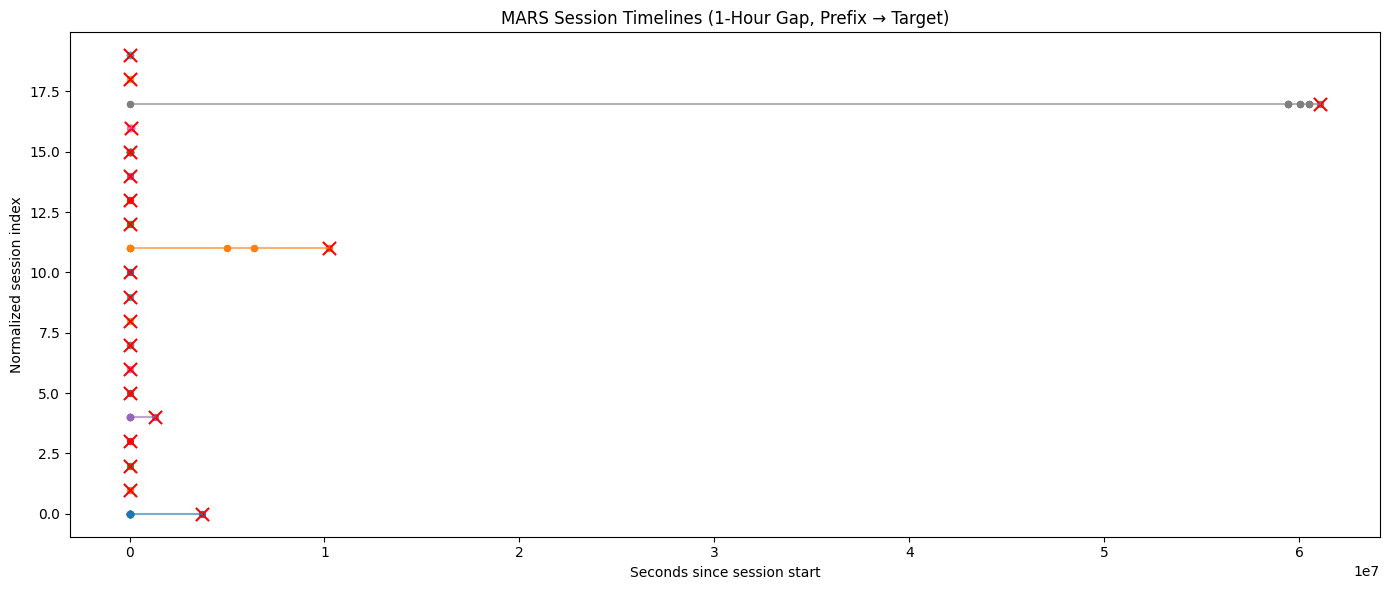

In [29]:
mars_sessions = pd.read_parquet("../data/processed/mars_sessions.parquet")
plot_session_timelines_from_sessions(
    mars_sessions,
    title="MARS Session Timelines (1-Hour Gap, Prefix → Target)"
)


### YooChoose: Session-based Prefix–Target Generation


Load YooChoose interactions

In [1]:
import pandas as pd
from pathlib import Path
import json

DATA_DIR = Path("../data/processed")

yoo_df = pd.read_parquet(DATA_DIR / "yoochoose_interactions.parquet")

required_cols = {"session_id", "item_id", "timestamp"}
assert required_cols.issubset(yoo_df.columns), yoo_df.columns

yoo_df = yoo_df.sort_values(["session_id", "timestamp"])


Generate prefix → target pairs (session-based)

In [2]:
MAX_PREFIX_LEN = 20
ROWS_PER_PART = 1_000_000

out_dir = DATA_DIR / "yoochoose_prefix_parts"
out_dir.mkdir(exist_ok=True)

rows = []
part_id = 0

for session_id, g in yoo_df.groupby("session_id"):
    items = g["item_id"].astype(str).tolist()

    if len(items) < 2:
        continue

    for i in range(1, len(items)):
        prefix = items[max(0, i - MAX_PREFIX_LEN):i]

        rows.append({
            "session_id": session_id,
            "prefix": " ".join(prefix),
            "target": items[i],
            "prefix_len": len(prefix)
        })

        if len(rows) >= ROWS_PER_PART:
            pd.DataFrame(rows).to_parquet(
                out_dir / f"yoochoose_prefix_target_part{part_id:04d}.parquet",
                index=False
            )
            rows.clear()
            part_id += 1

# flush remainder
if rows:
    pd.DataFrame(rows).to_parquet(
        out_dir / f"yoochoose_prefix_target_part{part_id:04d}.parquet",
        index=False
    )


Register YooChoose parts in the manifest

In [3]:
manifest_path = DATA_DIR / "sessionization_manifest.json"

with open(manifest_path, "r") as f:
    manifest = json.load(f)

yoo_parts = sorted(str(p) for p in out_dir.glob("*.parquet"))
manifest["yoochoose_prefix_parts"] = yoo_parts

with open(manifest_path, "w") as f:
    json.dump(manifest, f, indent=2)

print(f"Registered {len(yoo_parts)} YooChoose prefix parts")


Registered 24 YooChoose prefix parts
